In [1]:
%matplotlib notebook

In [2]:
from importlib import reload
from typing import Dict, Tuple, List, Union, Sequence, Optional

import numpy as np
from matplotlib import pyplot as plt

In [3]:
import qcodes as qc
from qcodes.dataset.measurements import Measurement, ParamSpec
from qcodes.instrument.base import Instrument, InstrumentBase
from qcodes.instrument.parameter import Parameter, ArrayParameter

from pytopo.qctools.instruments import create_inst
from pytopo.qctools import dataset2 as d2
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

In [23]:
class HardRabi(HardSweep):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, sweep_dims=['amplitude', 'detuning'], 
                         sweep_units=['a.u.', 'Hz'], **kw)
        
        self.add_parameter('start_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=0)
        self.add_parameter('stop_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=1)
        self.add_parameter('amp_points',get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
        self.add_parameter('start_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=-1)
        self.add_parameter('stop_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=1)
        self.add_parameter('det_points', get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
    def setup(self):
        self.amplitude(np.linspace(self.start_amp(), self.stop_amp(), self.amp_points()))
        self.detuning(np.linspace(self.start_det(), self.stop_det(), self.det_points()))
        super().setup()
        
    def get_dummy_data(self, tvals):       
        if type(tvals) not in [list, np.ndarray]:
            tvals = [tvals]
        
        def p(amp, det):
            fr = amp**2 / (det**2 + amp**2)
            return fr * np.cos((det**2 + amp**2)**.5)**2.

        p0 = p(*self.get_sweep_grid())
        data = np.outer(p0, np.exp(-tvals)).reshape(-1)
#         data[np.isnan(data)] = 1
        return data
        
        
class DummyTimeDomainDetector(HardSweepDetector):
    
    def get_td_data(self):
        data = self.sweeper.get_dummy_data(self.time())
        return data
    
    def __init__(self, name, **kw):
        super().__init__(name, inner_dims=['time'], inner_units=['ns'], **kw)
        
        self.add_parameter('start_time', set_cmd=None, unit='ns', initial_value=0)
        self.add_parameter('stop_time', set_cmd=None, unit='ns', initial_value=10)
        self.add_parameter('time_points', set_cmd=None, initial_value=11)
        
        self.data_params = []
        self.add_parameter('data', get_cmd=self.get_td_data, snapshot_value=False, unit='a.u.')
        self.data_params.append(self.data)
        
    def setup(self):
        self.time(np.linspace(self.start_time(), self.stop_time(), self.time_points()))
        super().setup()

In [24]:
rabi_swp = create_inst(HardRabi, 'rabi_swp', force_new_instance=True)
det = create_inst(DummyTimeDomainDetector, name='td_detector', force_new_instance=True)

station = qc.Station(rabi_swp, det)

Instrument rabi_swp already exists.
Instrument td_detector already exists.


(28611,) (51, 51, 11) ['amplitude', 'detuning', 'time'] ['a.u.', 'Hz', 'ns']


C:\Users\wopfa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


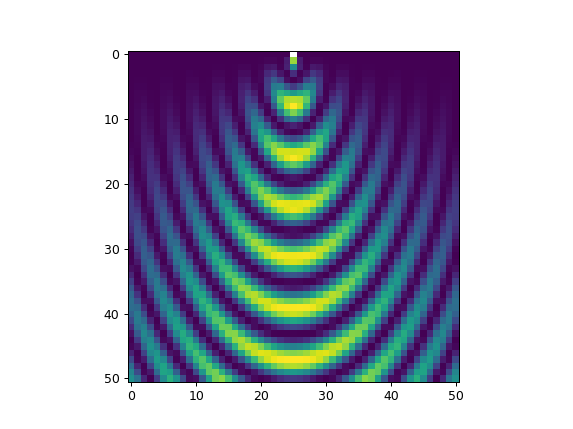

In [25]:
rabi_swp.start_amp(0)
rabi_swp.stop_amp(20)
rabi_swp.amp_points(51)
rabi_swp.start_det(-20)
rabi_swp.stop_det(20)
rabi_swp.det_points(51)
rabi_swp.setup()

det.set_sweeper(rabi_swp)
det.time_points(11)
det.setup()

data = det.data()
print(data.shape, det.sweep_shape, det.sweep_dims, det.sweep_units)

fig, ax = plt.subplots(1,1)
ax.imshow(data.reshape(det.sweep_shape)[..., 0])

In [48]:
exp = d2.select_experiment('sweep test', 'None')

ds = qc.dataset.data_set.new_data_set('my dataset')

for p in det.sweep_params:
    ds.add_parameter(ParamSpec(name=str(p), paramtype='array', label=p.label, unit=p.unit))

for p in det.data_params:
    ds.add_parameter(ParamSpec(name=str(p), paramtype='array', label=p.label, unit=p.unit,
                               depends_on=[str(p) for p in det.sweep_params]))


#     result = [(str(r[0]), r[1]) for r in det.get_sweep_coords()] + [(str(det.data), det.data())]  
#     ds.add_result(dict(result))
    
ds.mark_complete()

C:\Users\wopfa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [49]:
ds.run_id

7

In [17]:
# exp = d2.select_experiment('sweep test', 'None')

# meas = Measurement(exp=exp)
# meas.write_period = 1

# for p in det.sweep_params:
#     meas.parameters[str(p)] = ParamSpec(name=str(p), paramtype='numeric', label=p.label, unit=p.unit)

# for p in det.data_params:
#     meas.parameters[str(p)] = ParamSpec(name=str(p), paramtype='numeric', label=p.label, unit=p.unit, 
#                                         depends_on=[str(p) for p in det.sweep_params])

# with meas.run() as datasaver:
#     result = [r for r in det.get_sweep_coords()] + [(det.data, det.data())]
#     datasaver.add_result(*result)

In [50]:
ds2 = qc.load_by_id(ds.run_id)
# data = np.array(ds.get_values('td_detector_data')).reshape(-1)

# fig, ax = plt.subplots(1,1)
# ax.imshow(data.reshape(det.sweep_shape)[..., 0])

In [46]:
# ds.get_values('rabi_swp_amplitude')

In [51]:
ds2.get_parameters()

[rabi_swp_amplitude (array),
 rabi_swp_detuning (array),
 td_detector_time (array),
 td_detector_data (array)]

In [56]:
for p in ds2.get_parameters():
    d = np.array(ds2.get_values(p.name)).reshape(-1)
    print(d, d.size, d.dtype, np.where(np.isnan(d)))

[  0.   0.   0. ...,  20.  20.  20.] 28611 float64 (array([], dtype=int64),)
[-20. -20. -20. ...,  20.  20.  20.] 28611 float64 (array([], dtype=int64),)
[  0.   1.   2. ...,   8.   9.  10.] 28611 float64 (array([], dtype=int64),)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.67714751e-04
   6.16988088e-05   2.26977233e-05] 28611 float64 (array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285], dtype=int64),)
